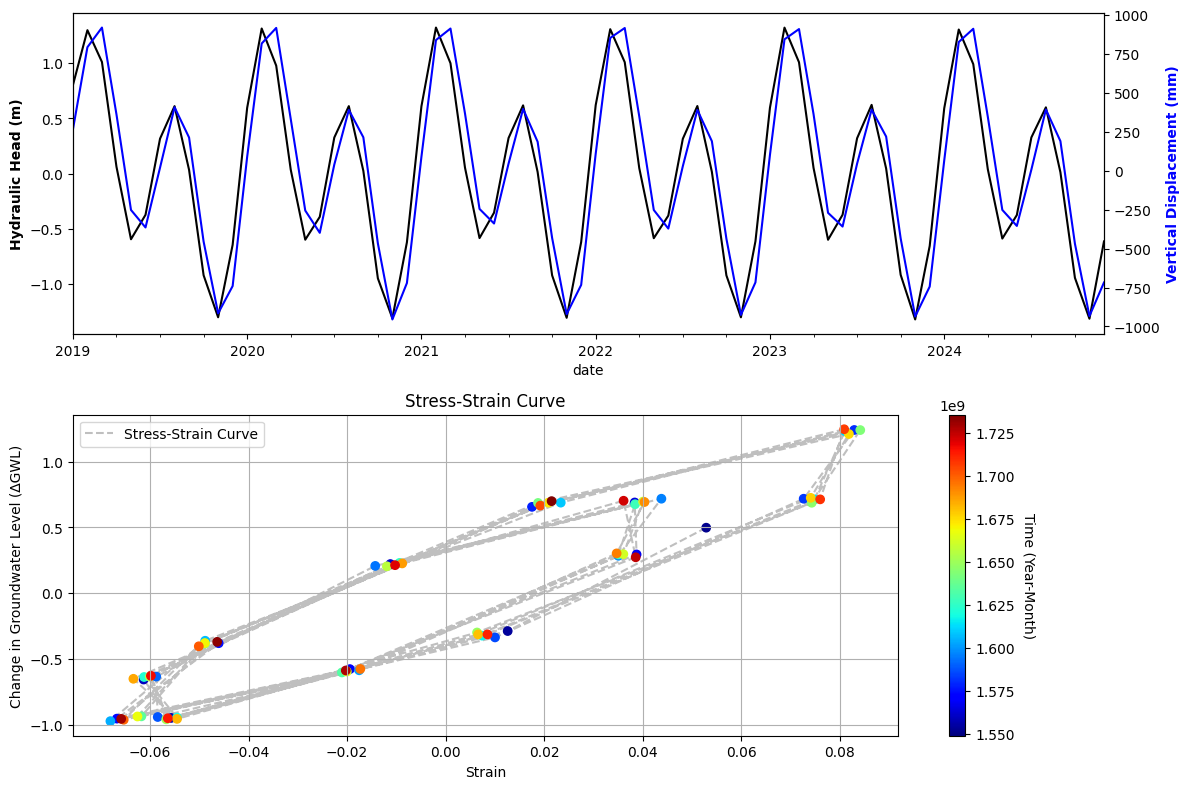

In [2]:
from my_packages import *
from appgeopy import *
import matplotlib.cm as cm

# Load the dataset
def load_data(file_path):
    """
    Load the dataset from a CSV file.

    Parameters:
        file_path (str): The path to the CSV file containing groundwater level and subsidence data.

    Returns:
        pd.DataFrame: A pandas DataFrame with date, GWL (groundwater level), and SUB (subsidence).
    """
    data = pd.read_csv(file_path)

    # Ensure column names are standardized
    data.columns = data.columns.str.strip().str.lower()

    # Check if 'date' column exists
    if 'date' not in data.columns:
        raise KeyError("The dataset must contain a 'date' column. Check the input file for column names.")

    data['date'] = pd.to_datetime(data['date'])  # Ensure the 'date' column is a datetime object
    return data

# Calculate stress (changes in groundwater level) and strain (normalized subsidence)
def calculate_stress_strain(data, aquifer_thickness):
    """
    Calculate stress and strain values from the dataset.

    Stress is defined as the change in groundwater level (∆GWL), and
    strain is defined as the normalized subsidence.

    Parameters:
        data (pd.DataFrame): A pandas DataFrame with columns 'GWL' (groundwater level) and 'SUB' (subsidence).
        aquifer_thickness (float): The thickness of the aquifer (in meters).

    Returns:
        pd.DataFrame: Updated DataFrame with stress (∆GWL) and strain (∆SUB).
    """
    data['Delta_GWL'] = data['gwl'].diff()  # Calculate change in groundwater level (stress)
    data['Delta_SUB'] = data['sub'].diff()  # Calculate change in subsidence

    # Normalize strain
    data['Strain'] = data['Delta_SUB'] / aquifer_thickness

    return data

# Enhanced plot function for combined visualization
def plot_combined(data, critical_slope=None):
    """
    Plot the stress-strain curve and original time-series data in the same figure.

    Parameters:
        data (pd.DataFrame): A pandas DataFrame with date, GWL, SUB, and calculated strain values.
        critical_slope (float, optional): Value to mark the elastic threshold on the stress-strain curve.
    """
    fig = plt.figure(figsize=(12, 8))

    # Plot original GWL and SUB time series
    ax1 = fig.add_subplot(211)
    data['gwl'].plot(ax=ax1, color='black', label='Hydraulic Head')
    ax1.set_ylabel("Hydraulic Head (m)", color="black", fontweight='bold')
    # ax1.legend(loc='best')

    ax2 = ax1.twinx()
    (data['sub'] * 1000).plot(ax=ax2, color='blue', label='Vertical Displacement')
    ax2.set_ylabel("Vertical Displacement (mm)", color="blue", fontweight='bold')
    # ax2.legend(loc='best')

    # Plot stress-strain curve
    ax3 = fig.add_subplot(212)
    ax3.plot(data['Strain'], data['Delta_GWL'], '--', color='gray', label='Stress-Strain Curve', alpha=0.5, zorder=1)
    # Normalize timestamps for color mapping
    timestamps = data.index.astype(np.int64) // 10**9  # Convert to seconds since epoch
    norm = plt.Normalize(timestamps.min(), timestamps.max())
    colors = cm.jet(norm(timestamps))
    
    scatter = ax3.scatter(data['Strain'], data['Delta_GWL'], c=timestamps, cmap='jet', norm=norm)

    if critical_slope is not None:
        ax3.axhline(critical_slope, color='red', linestyle='-', label='Elastic Threshold')
    ax3.set_xlabel('Strain')
    ax3.set_ylabel('Change in Groundwater Level (∆GWL)')
    ax3.set_title('Stress-Strain Curve')
    ax3.legend()
    ax3.grid(True)

    # Add colorbar for timeline
    cbar = fig.colorbar(scatter, ax=ax3, orientation='vertical')
    cbar.ax.set_ylabel('Time (Year-Month)', rotation=270, labelpad=15)

    fig.tight_layout()
    return fig

file_path = "GWL_SUB_table.csv"

# Load the dataset
data = load_data(file_path)
data = data.resample("M", on="date").mean()

# Calculate stress and strain
data = calculate_stress_strain(data, aquifer_thickness=10)

# Plot the combined figure
fig = plot_combined(data)

visualize.save_figure(fig, savepath="example.png")


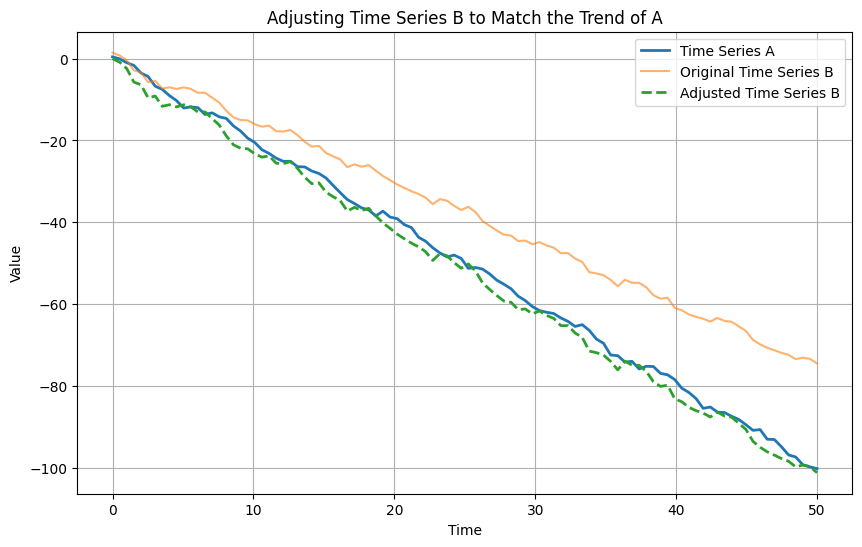

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Generate synthetic data for demonstration
time = np.linspace(0, 50, 100)
A = -2 * time + np.sin(time) + np.random.normal(scale=0.5, size=len(time))  # Time series A
B = -1.5 * time + np.cos(time) + np.random.normal(scale=0.5, size=len(time))  # Time series B

# Fit linear regression to calculate trends
model_A = LinearRegression().fit(time.reshape(-1, 1), A)
model_B = LinearRegression().fit(time.reshape(-1, 1), B)

# Calculate slopes (trends)
m_A = model_A.coef_[0]
m_B = model_B.coef_[0]

# Compute adjustment factor
k = m_A / m_B

# Adjust B to match the trend of A
B_adjusted = k * B

# Ensure B_adjusted starts from zero
B_adjusted -= B_adjusted[0]

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(time, A, label="Time Series A", linewidth=2)
plt.plot(time, B, label="Original Time Series B", alpha=0.6)
plt.plot(time, B_adjusted, label="Adjusted Time Series B", linestyle="--", linewidth=2)
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Adjusting Time Series B to Match the Trend of A")
plt.legend()
plt.grid()
plt.show()


In [7]:
model_B_adjusted = LinearRegression().fit(time.reshape(-1, 1), B_adjusted)
model_B_adjusted.coef_[0]

-2.0007192579783646